### Loading and preparing the data

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
train_dir = 'data/train'
val_dir = 'data/validation'
test_dir = 'data/test'

image_size = (160, 160) 
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,  
    width_shift_range=0.3,  
    height_shift_range=0.3, 
    shear_range=0.3, 
    zoom_range=0.3, 
    rotation_range=30, 
    brightness_range=[0.8, 1.2], 
    horizontal_flip=True, 
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test sets

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5972 images belonging to 7 classes.
Found 1280 images belonging to 7 classes.
Found 1284 images belonging to 7 classes.


### Setup pretrained model

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras

base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')

base_model.trainable = False


model = keras.Sequential([
        base_model,

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(), 
        keras.layers.Dropout(0.5),

        Dense(128, activation='relu'),  # Another fully connected layer
        BatchNormalization(),  # Batch normalization
        keras.layers.Dropout(0.5),  # Dropout for regularization

        Dense(68, activation='relu'),  # Another fully connected layer
        BatchNormalization(),  # Batch normalization
        keras.layers.Dropout(0.5),  # Dropout for regularization

        Dense(len(train_generator.class_indices), activation='softmax')
    ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train model

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30


C:\Users\laris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 139s 690ms/step - accuracy: 0.2116 - loss: 2.6792 - val_accuracy: 0.5789 - val_loss: 1.2050
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 150s 782ms/step - accuracy: 0.4008 - loss: 1.6575 - val_accuracy: 0.7188 - val_loss: 0.8339
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 161s 844ms/step - accuracy: 0.5043 - loss: 1.3383 - val_accuracy: 0.7664 - val_loss: 0.7171
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 181s 946ms/step - accuracy: 0.5541 - loss: 1.1626 - val_accuracy: 0.8164 - val_loss: 0.6344
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 167s 877ms/step - accuracy: 0.5996 - loss: 1.0845 - val_accuracy: 0.8211 - val_loss: 0.5770
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.6111 - loss: 1.0119 - val_accuracy: 0.8313 - val_loss: 0.5506
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.6309 - loss: 0.9810 - val_accuracy: 0.8430 - val_loss: 0.5119
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 190s 989ms/step - accuracy: 0.6621 - loss: 0.9229 - v

### Evaluate the model

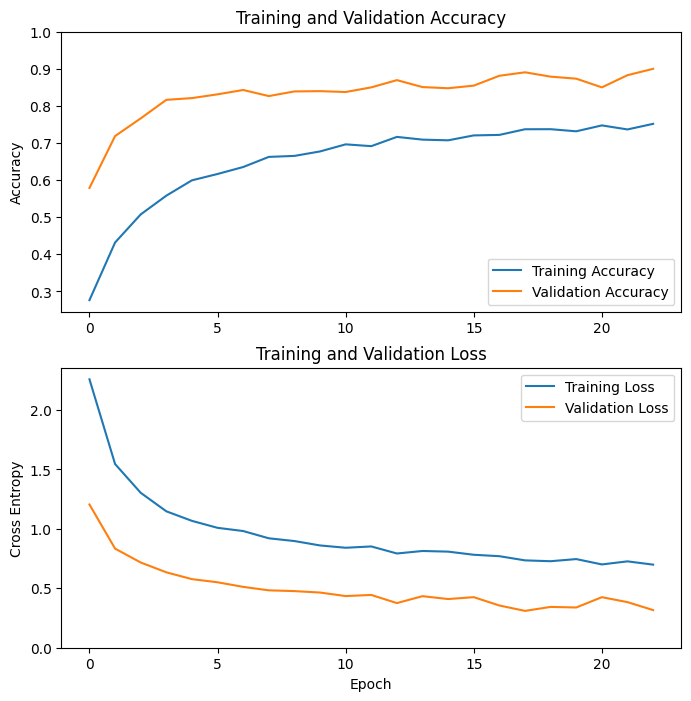

C:\Users\laris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.8920 - loss: 0.3376
Test Accuracy: 0.88


In [5]:
import matplotlib.pyplot as plt

# Extracting accuracy and loss from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the learning curves
plt.figure(figsize=(8, 8))

# Plotting training and validation accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])  # Adjust this based on your loss range
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.show()

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

## Fine tune the model

In [12]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_finetuned_model.keras', 
                                                monitor='val_loss', 
                                                save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5, 
                                                  restore_best_weights=True)

fine_tune_epochs = 27
total_epochs =  23 + fine_tune_epochs

fine_tune_history = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

Number of layers in the base model:  154


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 68)             │         8,772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 68)             │           272 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629,879 (10.03 MB)

 Trainable params: 2,232,431 (8.52 MB)

 Non-trainable params: 397,448 (1.52 MB)

Epoch 24/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 194s 914ms/step - accuracy: 0.7867 - loss: 0.6237 - val_accuracy: 0.9414 - val_loss: 0.2172
Epoch 25/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.7962 - loss: 0.5774 - val_accuracy: 0.9414 - val_loss: 0.2158
Epoch 26/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.8213 - loss: 0.5465 - val_accuracy: 0.9438 - val_loss: 0.2093
Epoch 27/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.8126 - loss: 0.5478 - val_accuracy: 0.9430 - val_loss: 0.1999
Epoch 28/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.8175 - loss: 0.5372 - val_accuracy: 0.9398 - val_loss: 0.2077
Epoch 29/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8370 - loss: 0.4932 - val_accuracy: 0.9438 - val_loss: 0.1937
Epoch 30/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.8356 - loss: 0.4990 - val_accuracy: 0.9555 - val_loss: 0.1752
Epoch 31/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.8541 - loss: 0.4638

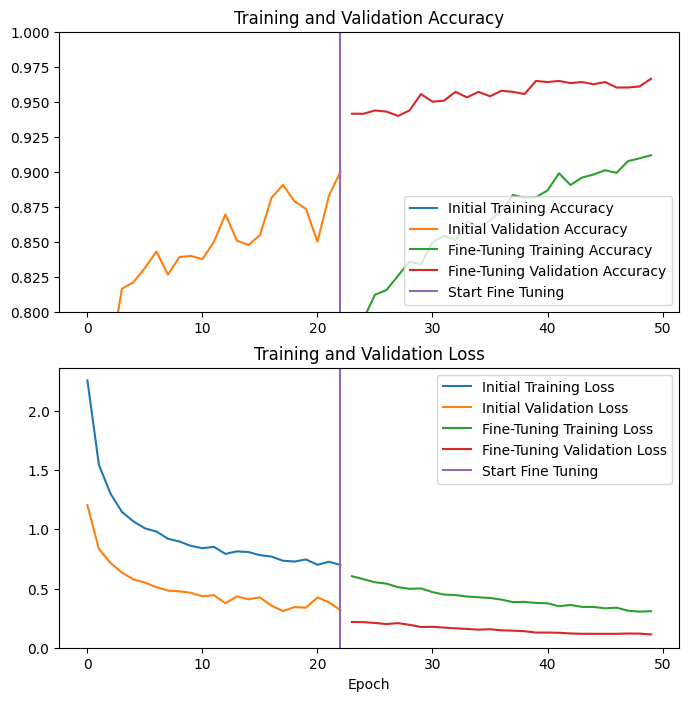

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 425ms/step - accuracy: 0.9562 - loss: 0.1338
Test Accuracy: 0.96


In [13]:
# Extracting accuracy and loss from initial training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extracting accuracy and loss from fine-tuning history
acc_fine = fine_tune_history.history['accuracy']
val_acc_fine = fine_tune_history.history['val_accuracy']
loss_fine = fine_tune_history.history['loss']
val_loss_fine = fine_tune_history.history['val_loss']

# Combine initial training and fine-tuning data
total_acc = acc + acc_fine
total_val_acc = val_acc + val_acc_fine
total_loss = loss + loss_fine
total_val_loss = val_loss + val_loss_fine

initial_epochs = len(acc)

# Plotting the learning curves
plt.figure(figsize=(8, 8))

# Plotting training and validation accuracy
plt.subplot(2, 1, 1)
plt.plot(range(initial_epochs), acc, label='Initial Training Accuracy')
plt.plot(range(initial_epochs), val_acc, label='Initial Validation Accuracy')
plt.plot(range(initial_epochs, initial_epochs + len(acc_fine)), acc_fine, label='Fine-Tuning Training Accuracy')
plt.plot(range(initial_epochs, initial_epochs + len(val_acc_fine)), val_acc_fine, label='Fine-Tuning Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(2, 1, 2)
plt.plot(range(initial_epochs), loss, label='Initial Training Loss')
plt.plot(range(initial_epochs), val_loss, label='Initial Validation Loss')
plt.plot(range(initial_epochs, initial_epochs + len(loss_fine)), loss_fine, label='Fine-Tuning Training Loss')
plt.plot(range(initial_epochs, initial_epochs + len(val_loss_fine)), val_loss_fine, label='Fine-Tuning Validation Loss')
plt.ylim([0, max(plt.ylim())])  # Adjust this based on your loss range
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

In [14]:
import pickle

model.save('finetunedmodelnew2.h5')
model.save('finetunedmodelnew2.keras')

with open('finetunedmodelnewhistory.pkl', 'wb') as f:
    pickle.dump(history.history, f)

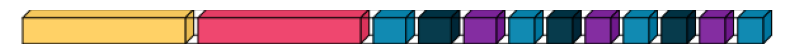

In [15]:
from tensorflow.keras.models import load_model
import visualkeras
from PIL import Image

model = load_model('finetunedmodelnew2.keras')

visualkeras.layered_view(model).save('model_visualization2.png')

img = Image.open('model_visualization2.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()
